# Hong Kong Interbank Balance Plot

#### Imports

In [1]:
import pandas as pd
import requests
from requests.adapters import Retry, HTTPAdapter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
import sqlite3


#### Globals

In [2]:
START = '2018-01-01'
END = str(pd.Timestamp.today().date())


#### Utility Functions

In [3]:
def url(Y, M, D):
    return (
        'https://www.hkma.gov.hk/eng/'
        'data-publications-and-research/data-and-statistics/'
        f'daily-monetary-statistics/{Y}/{M}/ms-{Y}{M}{D}/')


In [4]:
def interbank_balance(date):
    try:
        Y, M, D = date.split('-')
        sess = requests.Session()
        sess.mount('https://', HTTPAdapter(max_retries=Retry(total=50, backoff_factor=0.1)))
        resp = sess.get(url(Y, M, D))
        print(f'fetching {date}')
        soup = BeautifulSoup(resp.content)
        table = soup.select_one(
            '#interbank-liquidity + div + div div.collapsibles-accordion-content div.template-table table')
        trs = table.select('tr')
        td = trs[1].select('td')[1]
        clean_text = td.text.replace('mn', '').replace(
            '百萬', '').replace(',', '').strip()
        return float(clean_text)
    except (AttributeError, ):
        return None


#### Tests

In [5]:
for date in ['2022-06-01', '2022-08-01']:
    ib = interbank_balance(date)
    print(date, ib)


fetching 2022-06-01
2022-06-01 319990.0
fetching 2022-08-01
2022-08-01 165158.0


#### Fetch

If connection is banned, wait for a while and run this cell again. Program will only re-download failed fetch.

In [6]:
dates = [str(d.date())
         for d in pd.date_range(START, END)]
with sqlite3.connect('data.sqlite') as conn:
    cursor = conn.cursor()
    for d in dates:
        cursor.execute(f"SELECT * from interbank where Date='{d}'")
        rows = cursor.fetchall()
        if len(rows) == 0:
            val = interbank_balance(d)
            val = val if val is not None else 'NULL'
            cursor.execute(f'INSERT OR REPLACE INTO interbank (Date, Balance) VALUES ("{d}", {val})')
    conn.commit()

fetching 2023-07-30
fetching 2023-07-31
fetching 2023-08-01
fetching 2023-08-02
fetching 2023-08-03
fetching 2023-08-04
fetching 2023-08-05
fetching 2023-08-06
fetching 2023-08-07
fetching 2023-08-08
fetching 2023-08-09
fetching 2023-08-10
fetching 2023-08-11
fetching 2023-08-12
fetching 2023-08-13
fetching 2023-08-14
fetching 2023-08-15
fetching 2023-08-16
fetching 2023-08-17
fetching 2023-08-18
fetching 2023-08-19
fetching 2023-08-20
fetching 2023-08-21
fetching 2023-08-22
fetching 2023-08-23
fetching 2023-08-24
fetching 2023-08-25
fetching 2023-08-26
fetching 2023-08-27
fetching 2023-08-28
fetching 2023-08-29
fetching 2023-08-30
fetching 2023-08-31
fetching 2023-09-01
fetching 2023-09-02
fetching 2023-09-03
fetching 2023-09-04
fetching 2023-09-05
fetching 2023-09-06
fetching 2023-09-07
fetching 2023-09-08
fetching 2023-09-09
fetching 2023-09-10
fetching 2023-09-11
fetching 2023-09-12
fetching 2023-09-13
fetching 2023-09-14
fetching 2023-09-15
fetching 2023-09-16
fetching 2023-09-17


#### Plot

<Axes: title={'center': 'Hong Kong Interbank Balalnce'}, ylabel='million HKD'>

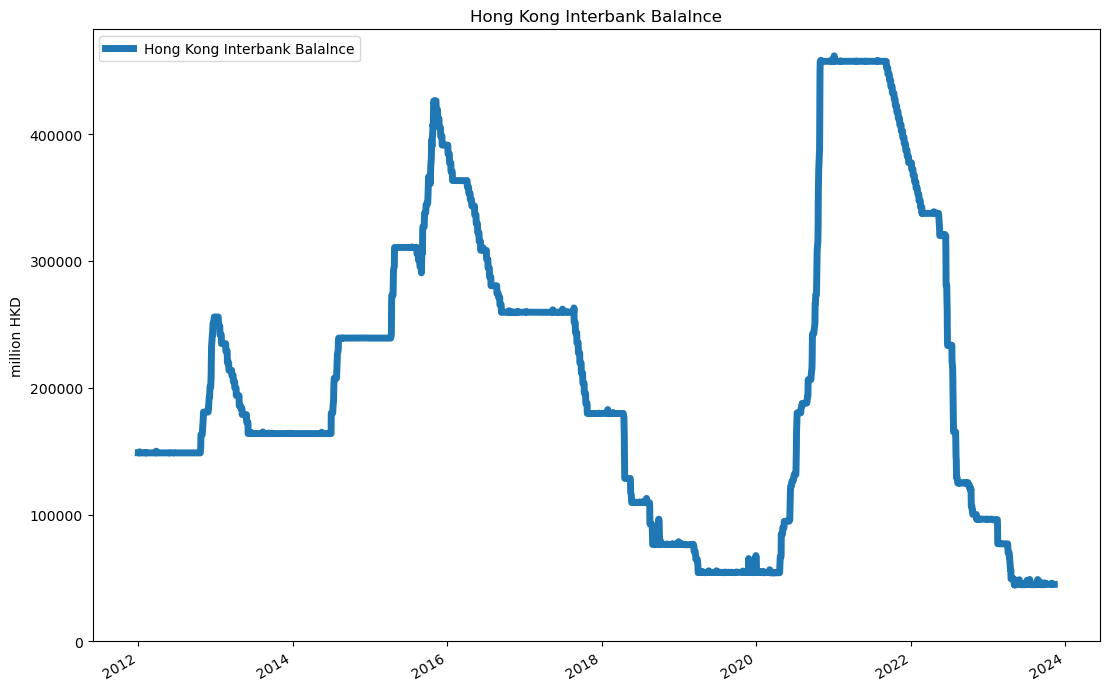

In [7]:
with sqlite3.connect('data.sqlite') as conn:
    cursor = conn.cursor()
    cursor.execute('SELECT * from interbank')
    data = cursor.fetchall()

clean = {d: v for d, v in dict(data).items() if v}
series = pd.Series(clean.values(),
                   index=pd.to_datetime(list(clean.keys())),
                   name='Hong Kong Interbank Balalnce').sort_index()
fig, ax = plt.subplots(1, 1, figsize=(13, 9))
series.plot(ax=ax, ylim=(0, None), title=series.name,
            legend=series.name, ylabel='million HKD', lw=5)


#### Recent

In [8]:
series.sort_index().iloc[-20:]

2023-10-13    45047
2023-10-16    45047
2023-10-17    45047
2023-10-18    45038
2023-10-19    45038
2023-10-20    45038
2023-10-24    45265
2023-10-25    45014
2023-10-26    45014
2023-10-27    45014
2023-10-30    45903
2023-10-31    45014
2023-11-01    44893
2023-11-02    44893
2023-11-03    44893
2023-11-06    44893
2023-11-07    44893
2023-11-08    44942
2023-11-09    44942
2023-11-10    44942
Name: Hong Kong Interbank Balalnce, dtype: int64